<div style="line-height:0.45">
<h1 style="color:#27E36C"> XGBoost 2 </h1>
<div style="margin-top: -4px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> VGG16_model + OpenCV + Tensorflow CUDA warnings
</span>
</div>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #to ignore CUDA warnings

In [2]:
import cv2
import glob
import pickle
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from keras.models import Model
from keras.layers import Conv2D
from keras.applications.vgg16 import VGG16
from keras.metrics import accuracy_score, MeanIoU

from google.colab import files

In [3]:
#%%script echo Remove comment if Colab in use
# Upload the zip archive
uploaded_zip = files.upload()

In [4]:
#%%script echo Remove comment if Colab in use
uploaded_sand = files.upload()

Saving Sandstone_Versa0400.tif to Sandstone_Versa0400.tif


In [4]:
# Extract the uploaded zip archive
with zipfile.ZipFile('Sandstones_arch.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
%%script echo Skip when Colab is used instead
print(os.listdir("./Sandstones/sand_training/"))

Skip when Colab is used instead


In [6]:
# Resize images (height  = X, width = Y)
SIZE_X = 1024
SIZE_Y = 996

In [7]:
""" Capture training image info as a list
N.B.
Use:
"for directory_path in glob.glob("./Sandstones/sand_training/"):" if not on Colab
"""

train_images = []
for directory_path in glob.glob("/content/Sandstones/sand_training/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)

# Convert list to array for machine learning processing
train_images = np.array(train_images)
train_images[:1]

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)

In [8]:
############## Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/Sandstones/sand_masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)

# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [9]:
""" Use customary x_train and y_train variables """
X_train = train_images
y_train = train_masks
#y_train = np.expand_dims(y_train, axis=3)

In [10]:
""" Load a VGG16 model wothout classifier/fully connected layers """

# Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))
## Make loaded layers as non-trainable. This is important to work properly with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

In [11]:
VGG_model.summary()  # => trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 996, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1024, 996, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1024, 996, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 512, 498, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 512, 498, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 512, 498, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 256, 249, 128)     0     

After the first 2 convolutional layers the image dimension changes. <br>
Therefore, for an easy comparison to Y (labels) it is better to just take first 2 convolutional layers and create a new model to extract features.


In [12]:
## New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 996, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1024, 996, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1024, 996, 64)     36928     
                                                                 
Total params: 38720 (151.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 38720 (151.25 KB)
_________________________________________________________________


In [13]:
""" Apply feature extractor to training data """
features=new_model.predict(X_train)

1/1 [==============================] - 11s 11s/step


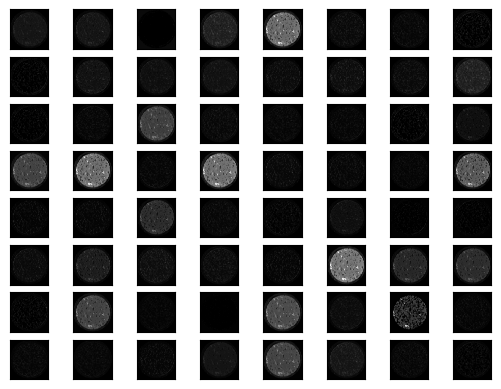

In [14]:
""" Visualize features """
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [15]:
y_train

array([[[29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        ...,
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29]],

       [[29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        ...,
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29]],

       [[29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        ...,
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29]],

       ...,

       [[29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        ...,
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29, 29],
        [29, 29, 29, ..., 29, 29

In [16]:
# Reassign 'features' as X to make it easy to follow
X = features
# Make X compatible for Random Forest to match Y labels
X = X.reshape(-1, X.shape[3])

# Reshape Y to match X
Y = y_train.reshape(-1)

In [17]:
""" Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0.
N.B. In our labels Y values 0 = unlabeled pixels.
"""
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print("{}\n".format(dataset['Label'].unique()))
print(dataset['Label'].value_counts())

[ 29  76 150 226]

29     3974068
76     3729575
150     320652
226     134937
Name: Label, dtype: int64


In [18]:
""" Exclude pixels with value 0.
N.B.
Sometimes unlabeled pixels may be given a value 0.
"""
dataset = dataset[dataset['Label'] != 0]

In [19]:
""" Drastically Reduce size of dataset to avoid crashing the session, due to RAM limits  """
desired_size = len(dataset) // 1200
desired_size

6799

In [20]:
reduced_df = dataset.sample(n=desired_size, random_state=42)

In [21]:
# Redefine X and Y for Random Forest
X_for_training = reduced_df.drop(labels = ['Label'], axis=1)
Y_for_training = reduced_df['Label']

## Convert to array
X_for_training2 = X_for_training.values
Y_for_training2 = Y_for_training.values

**Note:** <br>
It is possible to work with pandas dataframes instead of arrays by please beware that <br>
xboost drops columns with zero values which creates a mismatch between column names <br>
for training and future testing datasets. Then, it is safer to work with arrays.

In [22]:
Y_for_training

2038511    29
6614653    76
6938129    29
5734439    76
4314817    29
           ..
1073425    29
5667225    29
3128232    29
7838185    76
4730103    29
Name: Label, Length: 6799, dtype: uint8

In [23]:
""" Map targets, since XGBoost expects the class labels to be integers
starting from 0 and incrementing by 1.
"""
class_label_mapping = {label: idx for idx, label in enumerate(set(Y_for_training2))}
Y_for_training_mapped = [class_label_mapping[label] for label in Y_for_training2]

In [24]:
# Check if any element is equal to 0 in Y_for_training_mapped
if any(label == 0 for label in Y_for_training_mapped):
    print("0 exists in Y_for_training_mapped")

0 exists in Y_for_training_mapped


In [25]:
set(Y_for_training_mapped)

{0, 1, 2, 3}

<h2 style="color:#27E36C"> XGBOOST model </h2>

In [26]:
model = xgb.XGBClassifier()

# Train the model on training data
model.fit(X_for_training, Y_for_training_mapped)

## Save for future use
filename = '/content/model_XG.sav'
pickle.dump(model, open(filename, 'wb'))

<h3 style="color:#27E36C"> => Test on a different image </h3>

1/1 [==============================] - 0s 37ms/step


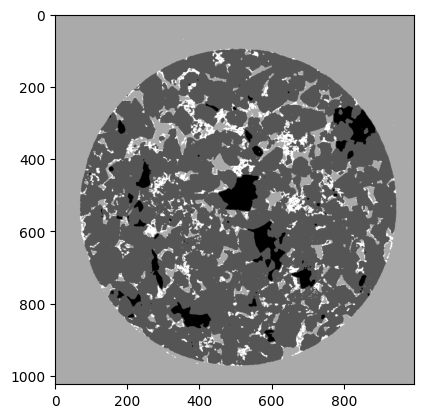

In [28]:
# Start segmenting future images
loaded_model = pickle.load(open(filename, 'rb'))

#### Read an external image
test_img = cv2.imread('/content/Sandstones/sand_test/Sandstone_Versa0400.tif', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

### Make predictions
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
prediction = loaded_model.predict(X_test_feature)

### View and save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('/content/ouput_400_segmented.jpg', prediction_image, cmap='gray')

<h3 style="color:#27E36C"> => Check accuracy and IoU </h3>

In [33]:
#### Read an external image
validation_img = cv2.imread('/content/Sandstones/sand_test/Sandstone_Versa0400.tif', cv2.IMREAD_COLOR)
validation_img = cv2.resize(validation_img, (SIZE_Y, SIZE_X))
validation_img = cv2.cvtColor(validation_img, cv2.COLOR_RGB2BGR)
validation_img = np.expand_dims(validation_img, axis=0)
validation_img[:2]

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)

In [34]:
### Make predictions
X_validation_feature = new_model.predict(validation_img)
X_validation_feature = X_validation_feature.reshape(-1, X_validation_feature.shape[3])
prediction_validation = loaded_model.predict(X_validation_feature)
prediction_validation

1/1 [==============================] - 0s 23ms/step


array([2, 2, 2, ..., 2, 2, 2])

In [35]:
set(prediction_validation)

{0, 1, 2, 3}

In [29]:
# Load ground truth image (Mask)
truth = cv2.imread('/content/Sandstone_Versa0400.tif', 0).reshape(-1)

1/1 [==============================] - 0s 19ms/step


In [36]:
set(truth)

{29, 76, 150, 226}

In [37]:
""" Map targets """
class_label_mapping = {label: idx for idx, label in enumerate(set(truth))}
truth_ok = [class_label_mapping[label] for label in truth]
set(truth_ok)

{0, 1, 2, 3}

In [39]:
# Pixel accuracy - not a good metric for semantic segmentation!
print ("Accuracy = ", accuracy_score(truth_ok, prediction_validation))

Accuracy =  0.9666066610190763


**Recap:** <br>
IOU = true_positive / (true_positive + false_positive + false_negative).

In [40]:
num_classes = 5

## Built keras function
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(truth_ok, prediction_validation)
print("Mean IoU =", IOU_keras.result().numpy())

##### Calculate I0U for each class
values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[2,1]+ values[3,1]+ values[4,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,1] + values[2,3] + values[1,2]+ values[3,2]+ values[4,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,1] + values[3,2] + values[3,4] + values[1,3]+ values[2,3]+ values[4,3])
class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,2] + values[4,3] + values[1,4]+ values[2,4]+ values[3,4])

print(values)
print()
print("IoU Class 1 =", class1_IoU)
print("IoU Class 2 =", class2_IoU)
print("IoU Class 3 =", class3_IoU)
print("IoU Class 4 =", class4_IoU)

Mean IoU = 0.85246015
[[3.23040e+04 3.02000e+02 2.30000e+01 0.00000e+00 0.00000e+00]
 [1.25100e+03 4.57198e+05 2.96900e+03 8.36800e+03 0.00000e+00]
 [0.00000e+00 1.55100e+03 4.63975e+05 3.75500e+03 0.00000e+00]
 [0.00000e+00 1.19680e+04 3.87100e+03 3.23690e+04 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]

IoU Class 1 = 0.94843733
IoU Class 2 = 0.9713255
IoU Class 3 = 0.5365235
IoU Class 4 = nan


<ipython-input-40-bb2a4aab67a4>:13: RuntimeWarning: invalid value encountered in float_scalars
  class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,2] + values[4,3] + values[1,4]+ values[2,4]+ values[3,4])
